# Non-minimax Method for Barycenter Computation
**GPU-only implementation.**

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm, tqdm_notebook

import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

import os, sys
sys.path.append("..")

import torch
from torch import nn
from torch.nn import functional as F

from scipy.stats import ortho_group
from scipy.linalg import sqrtm

from src.icnn import DenseICNN
from src.plotters import plot_training_phase
from src.tools import *
from src import distributions
from src import benchmarks
import itertools
import time
import pandas as pd

from sklearn.decomposition import PCA

from copy import deepcopy

In [2]:
DIM = 128
OUTPUT_SEED = 0xBADBEEF
GPU_DEVICE = 0
WANDB_LOG = False
OUTPUT_FOLDER = None # '../results/hd/rectangles/'

In [3]:
assert DIM > 1

BATCH_SIZE = 1024

LAMBDA = 10
R_LAMBDA = 5
D_LR = 1e-3
MAX_ITER = 10001

PLOT_FREQ = 999
SCORE_FREQ = 100

# Parameters for input distributions
NUM = 4 #5
# ALPHAS = np.array([1. / NUM for _ in range(NUM)])
ALPHAS = np.array([0.1, 0.2, 0.3, 0.4])
assert NUM == len(ALPHAS)

CASE = {
    'type' : 'EigWarp', 
    'sampler' : 'Rectangles', #'SwissRoll' (2D only!) or  'Gaussians'
    'params' : {'num' : NUM, 'alphas' : ALPHAS, 'min_eig' : .5, 'max_eig' : 2}
}

# CASE = {
#     'type' : 'Two Rectangles',
# }

# CASE = {
#     'type' : 'Two Crusts',
# }

# CASE = {
#     'type' : 'Rotated Gaussian Mixture 4'
# }

# CASE = {
#     'type' : 'Bike Posterior'
# }

NAME = f'W2CB__{CASE["type"]}_NUM={NUM}_DIM={DIM}_C={LAMBDA}_R={R_LAMBDA}_{OUTPUT_SEED}'

# Log to online wandb?
WANDB_CONFIG = {
    'name' : NAME,
    'entity' : "gunsandroses", 
    'project' : "bar-methods-comparison",
}

if WANDB_LOG:
    import wandb
    from src.tools import fig2img
    wandb.init(
        **WANDB_CONFIG,
        config={
            'CASE' : CASE,
            'OUTPUT_SEED' : OUTPUT_SEED,
            'DIM' : DIM,
            'NUM' : NUM,
            'ALPHAS' : ALPHAS,
            "D_LR" : D_LR,
            'BATCH_SIZE' : BATCH_SIZE,
            'LAMBDA' : LAMBDA,
            'R_LAMBDA' : LAMBDA,
        }
    )

In [4]:
if OUTPUT_FOLDER is not None:
    if not os.path.exists(OUTPUT_FOLDER):
        os.makedirs(OUTPUT_FOLDER)

In [5]:
assert torch.cuda.is_available()
torch.cuda.set_device(GPU_DEVICE)

np.random.seed(OUTPUT_SEED)
torch.manual_seed(OUTPUT_SEED)

## Initializing distributions

In [6]:
if CASE['type'] == 'EigWarp':
    if CASE['sampler'] == 'Gaussians':
        sampler = distributions.StandardNormalSampler(dim=DIM)
    elif CASE['sampler'] == 'SwissRoll':
        assert DIM == 2
        sampler = distributions.SwissRollSampler()
    elif CASE['sampler'] == 'Rectangles':
        sampler = distributions.CubeUniformSampler(dim=DIM, normalized=True, centered=True)
    
    benchmark = benchmarks.EigenWarpBenchmark(sampler, **CASE['params'], requires_grad=True, max_iter=250, tol=1e-4)
    
elif CASE['type'] == 'Two Rectangles':
    assert DIM == 2
    assert N == 2
    sampler = distributions.CubeUniformSampler(dim=2, normalized=True, centered=True)
    benchmark = benchmarks.LocationScatterBenchmark(
        sampler, means=[[-2, -2], [2, 2]], 
        covs=[[[2, 0], [0, 1]], [[1, 0], [0, 2]]],
        requires_grad=True
    )
    
elif CASE['type'] == 'Two Crusts':
    assert N == 2
    ball_crust = distributions.StandardNormalScaler(
        distributions.BallCrustUniformSampler(dim=DIM),
        requires_grad=True
    )
    cube_crust = distributions.StandardNormalScaler(
        distributions.CubeCrustUniformSampler(dim=DIM),
        requires_grad=True
    )
    benchmark = benchmarks.Wasserstein2BarycenterBenchmark(
        [cube_crust, ball_crust], requires_grad=True
    )
    
elif CASE['type'] == 'Rotated Gaussian Mixture 4':
    assert DIM == 2
    assert N == 2
    
    samplers = []
    theta = np.pi / 4
    
    for n in range(2):
        sampler = distributions.MixN2GaussiansSampler(n=2)
        normalizer = distributions.StandardNormalScaler(sampler)
        rotation = torch.tensor(
            [[np.cos(n*theta), -np.sin(n*theta)], 
             [np.sin(n*theta),  np.cos(n*theta)]],
            device='cuda'
        )
        transformer = distributions.LinearTransformer(weight=rotation, base_sampler=normalizer, requires_grad=True)
        samplers.append(transformer)
    
    benchmark = benchmarks.Wasserstein2BarycenterBenchmark(samplers, requires_grad=True)
    
elif CASE['type'] == 'Bike Posterior':
    assert DIM == 8
    assert NUM == 5    
    SCALE = np.sqrt(1e7)
    samplers = []
    for n in range(5):
        posterior = np.load('../data/bike_posterior/samples_0_{}.npy'.format(n))[:, 1:]
        posterior -= posterior.mean(axis=0)
        posterior *= SCALE
        samplers.append(distributions.TensorDatasetSampler(posterior, device='cuda', requires_grad=True))

    full_posterior = np.load('../data/bike_posterior/samples_0_all.npy')[:, 1:]
    full_posterior -= full_posterior.mean(axis=0)
    full_posterior *= SCALE

    bar_sampler = distributions.TensorDatasetSampler(full_posterior, device='cuda', requires_grad=True)

    benchmark = benchmarks.Wasserstein2BarycenterBenchmark(samplers, bar_sampler=bar_sampler, requires_grad=True, device='cuda')

## Discriminators Setup

In [7]:
D = DenseICNN(
    DIM, rank=2, hidden_layer_sizes=[max(64, 2*DIM), max(64, 2*DIM), max(32, DIM)],
    dropout=0.01, strong_convexity=0.0001
).cuda()

print(np.sum([np.prod(list(p.shape)) for p in D.parameters()]), 'parameters in Discriminative Network')

# Manual weights init
for p in D.parameters():
    p.data = torch.randn(p.shape, device='cuda', dtype=torch.float32) / 2.

344832 parameters in Discriminative Network


In [8]:
X0_sampler = distributions.StandardNormalSampler(dim=DIM, requires_grad=True)
D_opt = torch.optim.Adam(D.parameters(), lr=1e-3, betas=(0.8, 0.9), weight_decay=1e-7)

D.train(True)
loss = np.inf

for iteration in tqdm(range(10000)):
    X = (X0_sampler.sample(BATCH_SIZE)).detach() * 4
    X.requires_grad_(True)

    loss = F.mse_loss(D.push(X), X.detach())
    loss.backward()
    D_opt.step(); D_opt.zero_grad()
    D.convexify()
    
    if loss.item() < 1e-2:
        break
    
    if iteration % 500 == 0:
        clear_output(wait=True)
        print('Pretraining the discriminator for D.push(x)=x')
        print('Current loss:', loss.item())
        
print('Final Loss:', loss.item())

 95%|█████████▌| 9523/10000 [01:22<00:04, 108.62it/s]

Pretraining the discriminator for D.push(x)=x
Current loss: 0.023868778720498085


100%|██████████| 10000/10000 [01:26<00:00, 115.00it/s]

Final Loss: 0.02393200434744358


In [9]:
D_list = nn.ModuleList([deepcopy(D) for _ in range(benchmark.num)]).cuda()
D_conj_list = nn.ModuleList([deepcopy(D) for _ in range(benchmark.num)]).cuda()

## PCA

In [10]:
pca = PCA(n_components=2)

class Identity:
    pass

if benchmark.bar_sampler is not None:
    pca.fit(benchmark.bar_sampler.sample(100000).cpu().detach().numpy())
elif benchmark.gauss_bar_sampler is not None:
    pca.fit(benchmark.gauss_bar_sampler.sample(100000).cpu().detach().numpy())
else:
    pca = Identity()
    pca.transform = lambda x: x
    
# No PCA for dim=2
if DIM == 2:
    pca = Identity()
    pca.transform = lambda x: x

## Main training

In [11]:
D_opt = torch.optim.Adam(
    D_list.parameters(), lr=D_LR,
    betas=(0.8, 0.99), weight_decay=1e-8
)
D_conj_opt = torch.optim.Adam(
    D_conj_list.parameters(), lr=D_LR,
    betas=(0.4, 0.4), weight_decay=1e-8
)

loss_history = []
L2_UVP_history = [[] for _ in range(benchmark.num)]
BW2_UVP_history = [[] for _ in range(benchmark.num)]
cycle_UVP_history = [[] for _ in range(benchmark.num)]
congruence_UVP_history = []
time_elapsed = []
full_log = {}

if hasattr(benchmark, 'gauss_bar_cost'):
    print('Gaussian Barycenter Cost:', benchmark.gauss_bar_cost)
    
if hasattr(benchmark, 'bar_cost'):
    print('Barycenter Cost:', benchmark.bar_cost)

Gaussian Barycenter Cost: 16.244461059570312
Barycenter Cost: 16.244461059570312


In [12]:
proposed_sampler = distributions.StandardNormalSampler(dim=benchmark.dim, requires_grad=True)

In [13]:
it = 0

Iteration: 9991
Weighted L2-UVP: 2.2369469184428454
Weighted Cycle-UVP: 1.335883271927014
Congruence-UVP: 0.8465261617675424


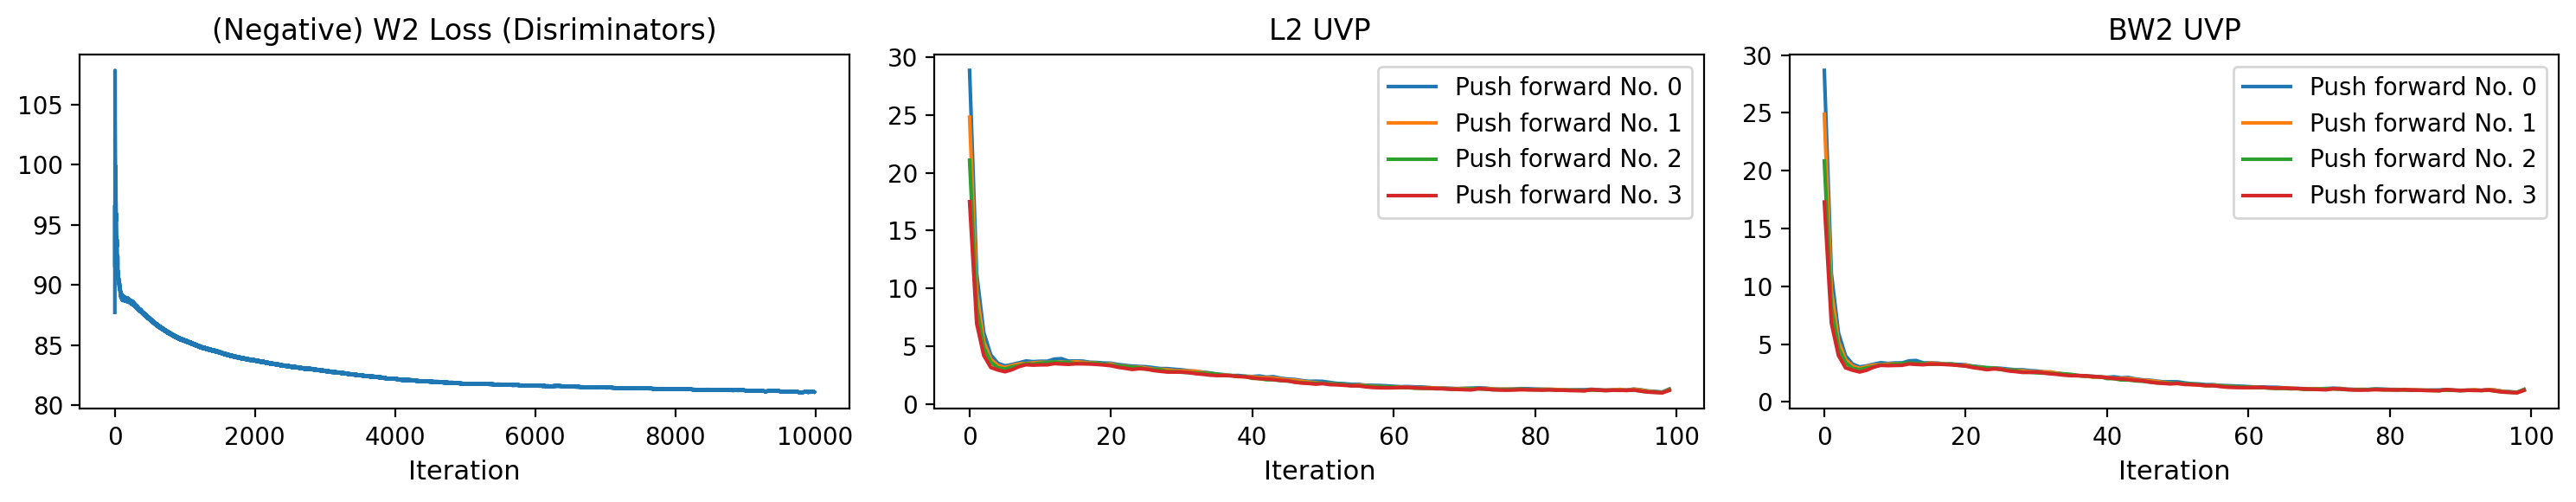

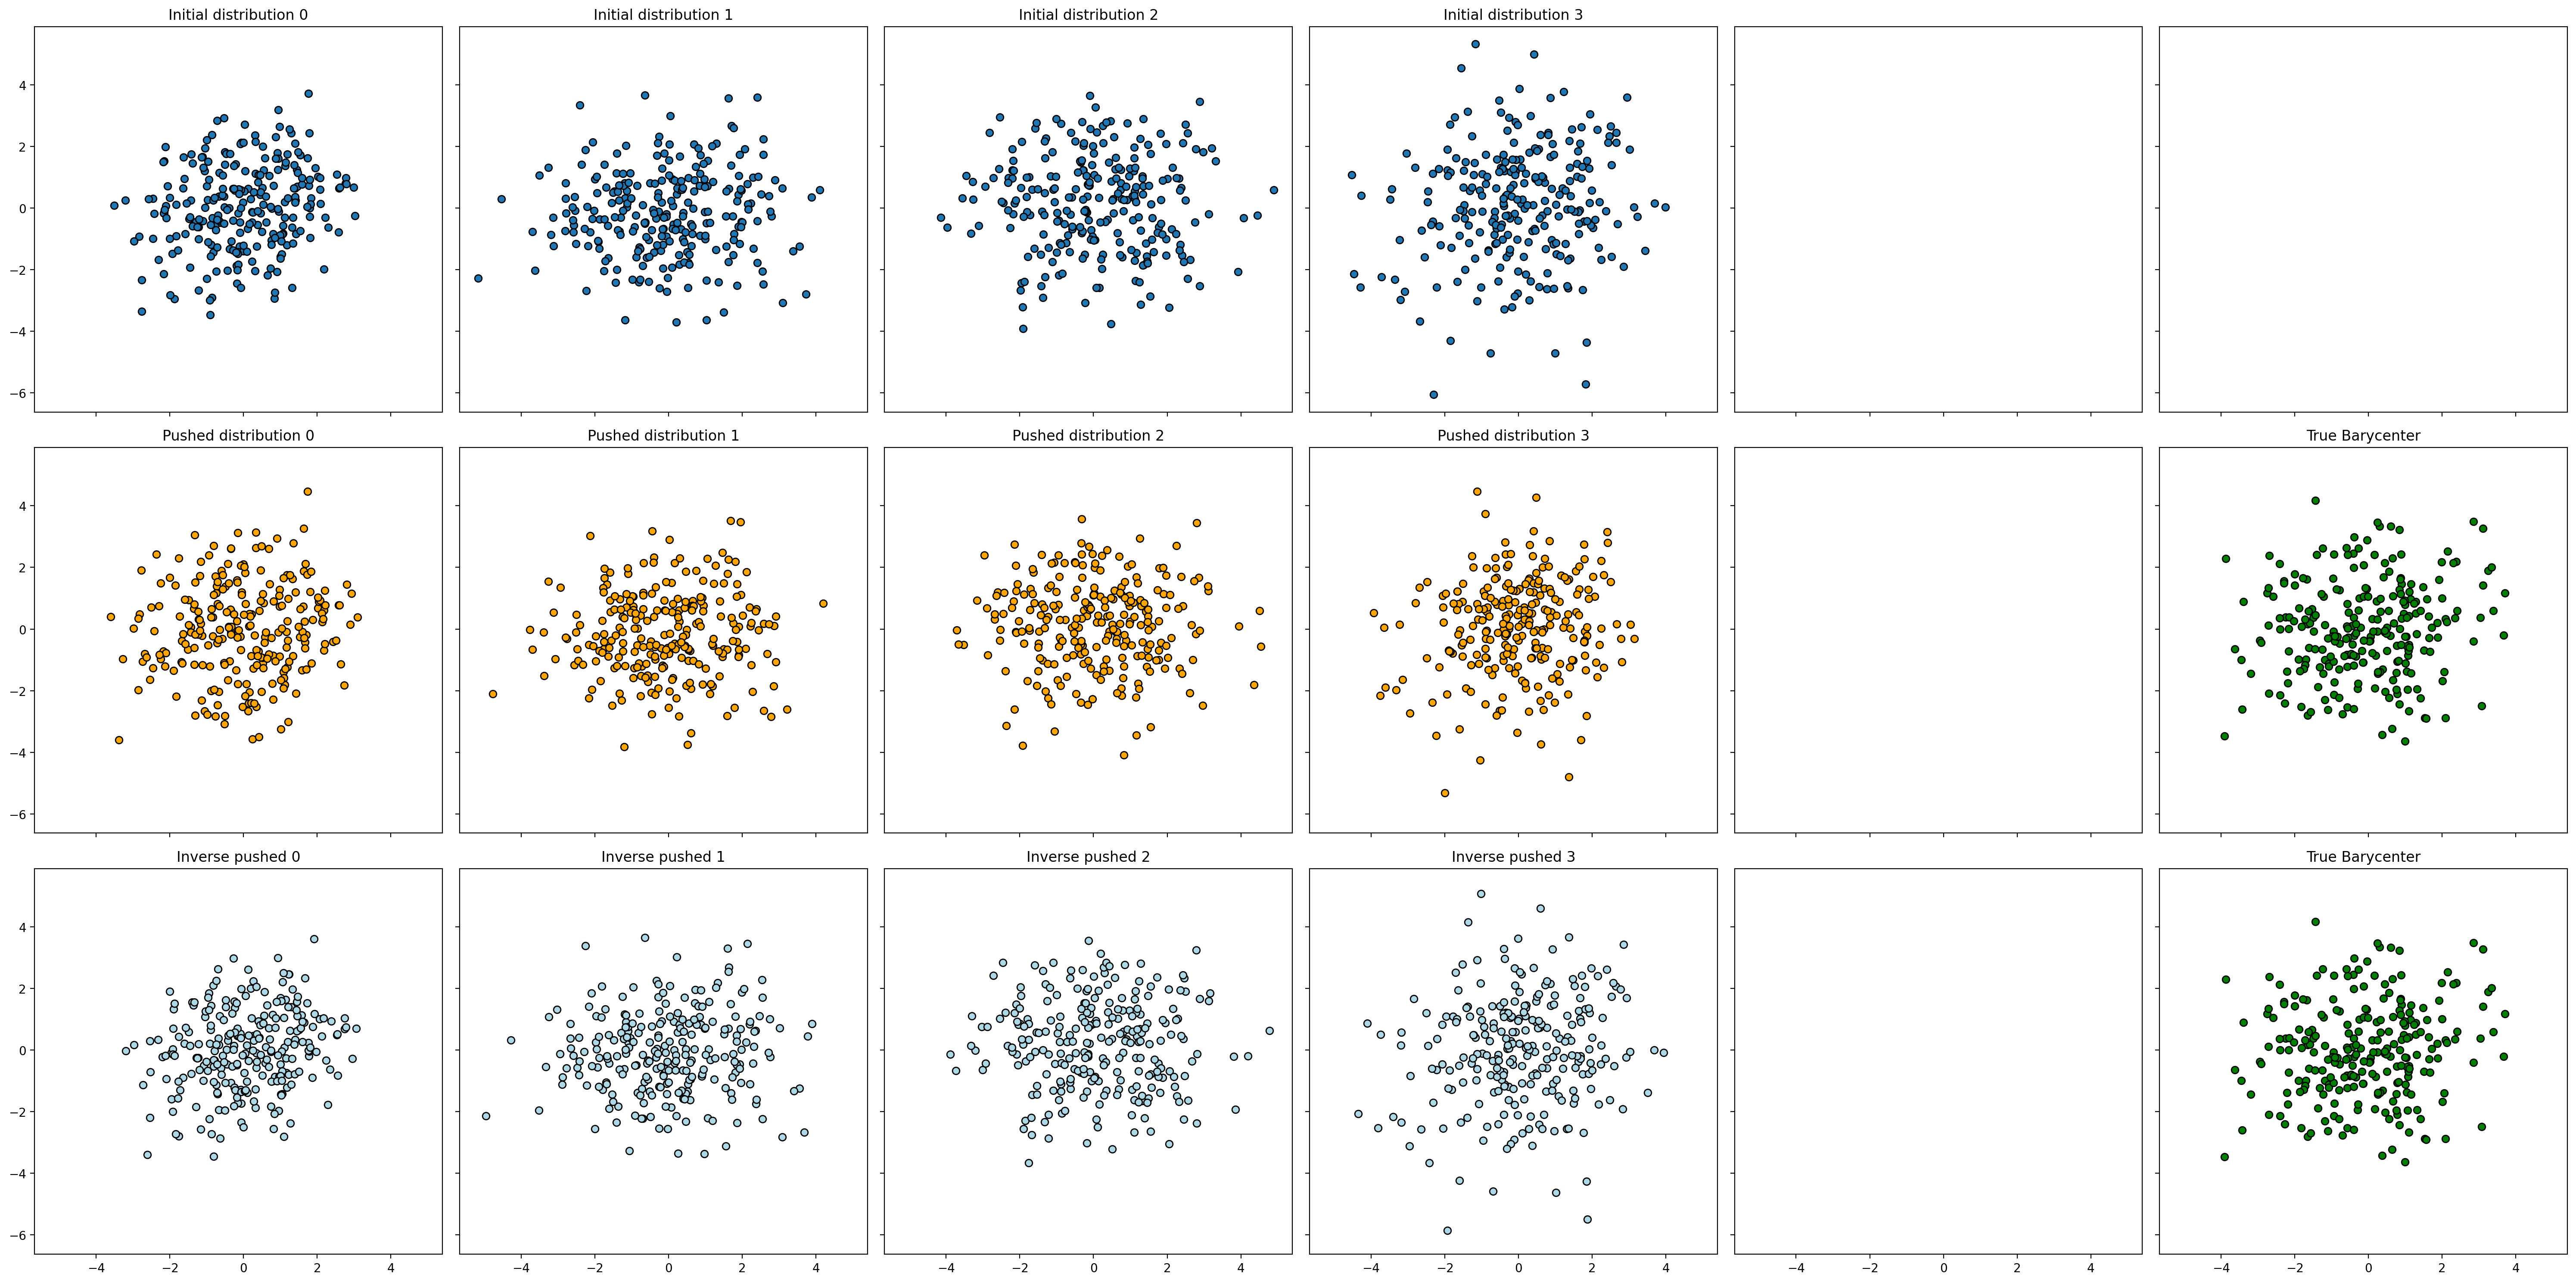

In [14]:
last_plot_it = -1
last_score_it = -1

while it < MAX_ITER:
    it += 1
    start_time = time.time()
    D_list.train(True); D_conj_list.train(True); 
    loss = 0.
    
    for n in range(benchmark.num):
        X = benchmark.samplers[n].sample(BATCH_SIZE)
        X_inv = D_list[n].push(X).detach()
        loss += benchmark.alphas[n] * ((X_inv * X).sum(dim=1).reshape(-1, 1) - D_conj_list[n](X_inv)).mean()
    
    log = {'pure_loss' : loss.item()}
    
    # Cycle Loss
    cycle_loss = 0.
    for n in range(benchmark.num):
        X = benchmark.samplers[n].sample(BATCH_SIZE)
        
        # Cycle loss
        cycle_loss += benchmark.alphas[n] * ((D_conj_list[n].push(D_list[n].push(X)) - X.detach()) ** 2).mean()

    loss += LAMBDA * cycle_loss
    
    # Congruence Regularization Loss
    reg_loss = 0.
    
    Y = torch.cat(
        [proposed_sampler.sample(BATCH_SIZE).detach()] +
        [D_list[n].push(benchmark.samplers[n].sample(BATCH_SIZE)).detach() for n in range(benchmark.num)],
        dim=0
    ).detach()
    
    for n in range(benchmark.num):
        reg_loss += benchmark.alphas[n] * D_conj_list[n](Y)
    reg_loss -= ((Y ** 2).sum(dim=1) / 2).reshape(-1, 1)
    reg_loss = torch.relu(reg_loss).mean()
    
    loss += R_LAMBDA * reg_loss
    
    loss_history.append(loss.item())
    loss.backward()
    D_opt.step(); D_conj_opt.step()
    D_opt.zero_grad(); D_conj_opt.zero_grad(); 
    
    for n in range(benchmark.num):
        D_conj_list[n].convexify()
        D_list[n].convexify()
        
    time_elapsed.append(time.time() - start_time)
        
    log = {
        **log,
        'full_loss' : loss.item(),
        'cycle_loss_XYX' : cycle_loss.item(),
        'reg_loss' : reg_loss.item(),
        'time' : time_elapsed[-1],
    }        
    
    
    # Scoring
    if it - last_score_it >= SCORE_FREQ:
        last_score_it = it
        
        if benchmark.bar_maps is not None:
            L2_UVP = score_forward_maps(benchmark, D_list)
            for n in range(benchmark.num):
                L2_UVP_history[n].append(L2_UVP[n])  
                log[f'L2 UVP {n}'] = L2_UVP[n]   
                
        if benchmark.bar_sampler is not None:
            BW2_UVP = score_pushforwards(benchmark, D_list)
            for n in range(benchmark.num):
                BW2_UVP_history[n].append(BW2_UVP[n])    
                log[f'BW2 UVP {n}'] = BW2_UVP[n]
                
        cycle_UVP = score_cycle_consistency(benchmark, D_list, D_conj_list)
        for n in range(benchmark.num):
            cycle_UVP_history[n].append(cycle_UVP[n])    
            log[f'cycle UVP {n}'] = cycle_UVP[n]
        
        if benchmark.bar_sampler is not None:
            congruence_UVP = score_congruence(benchmark, D_conj_list)
            congruence_UVP_history.append(congruence_UVP)
            log[f'congruence UVP {n}'] = congruence_UVP
    
    full_log[it] = log
    if WANDB_LOG:
        wandb.log(log, step=it)
    
    # Plotting
    if it - last_plot_it >= PLOT_FREQ:
        clear_output(wait=True)
        print('Iteration:', it)
        print('Weighted L2-UVP:', np.mean(L2_UVP_history[-10:], axis=1) @ benchmark.alphas)
        print('Weighted Cycle-UVP:', np.mean(cycle_UVP_history[-10:], axis=1) @ benchmark.alphas)
        print('Congruence-UVP:', np.mean(congruence_UVP_history[-10:]))
        last_plot_it = it        
        
        # Plotting Metrics
        fig, axes = plt.subplots(1, 3, figsize=(15, 3), dpi=200)
        axes[0].set_title('(Negative) W2 Loss (Disriminators)', fontsize=12)
        axes[0].set_xlabel('Iteration', fontsize=11)
        axes[0].plot(ewma(loss_history))
        
        axes[1].set_title('L2 UVP', fontsize=12)
        axes[1].set_xlabel('Iteration', fontsize=11)
        for n in range(benchmark.num):
            if L2_UVP_history[n] != []:
                axes[1].plot(ewma(L2_UVP_history[n], span=3), label=f'Push forward No. {n}')
        axes[1].legend()
        
        
        axes[2].set_title('BW2 UVP', fontsize=12)
        axes[2].set_xlabel('Iteration', fontsize=11)
        for n in range(benchmark.num):
            if BW2_UVP_history[n] != []:
                axes[2].plot(ewma(BW2_UVP_history[n], span=3), label=f'Push forward No. {n}')
        axes[2].legend()
        fig.tight_layout(); plt.show(); plt.close(fig)
        
        # Plotting scatter plots
        fig, ax = plot_training_phase(benchmark, pca, D_list, D_conj_list)
        fig.tight_layout();
        
        if WANDB_LOG:
            wandb.log({'map' : [wandb.Image(fig2img(fig))]}, step=it)
        
        plt.show(); plt.close(fig)

In [15]:
if OUTPUT_FOLDER is not None:
    pd.DataFrame.from_dict(full_log).T.to_csv(os.path.join(OUTPUT_FOLDER, NAME + '.csv'))